In [2]:
from torch.utils.data import DataLoader, random_split
# from utils.preprocess import FaceCompletionDataset
from utils.network_seq_contour import Parser
from utils.models import Generator, Discriminator
import torchvision.models as models
import torch
import copy
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import torch
import random
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor

class FaceCompletionDataset(Dataset):
    def __init__(self, image_dir, block_size=(64, 64)):
        self.image_dir = image_dir
        self.block_size = block_size
        self.image_list = os.listdir(image_dir)[:64*5]
        
    def __len__(self):
        return len(self.image_list)
    
    def random_block_mask(self, image, block_size=(64, 64)):
        h, w, _ = image.shape
        x = random.randint(0, w - block_size[0])
        y = random.randint(0, h - block_size[1])
        mask = np.zeros((h, w), dtype=np.uint8)
        mask[y:y + block_size[1], x:x + block_size[0]] = 1
        masked_image = image.copy()
        noise = np.random.randint(0, 256, size=(block_size[1], block_size[0], 3), dtype=np.uint8)
        masked_image[y:y + block_size[1], x:x + block_size[0]] = noise
        return masked_image, mask
    
    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_list[idx])
        image = cv2.imread(image_path)

        masked_image, mask = self.random_block_mask(image)
        #mask = np.expand_dims(mask, axis=0)
    
        image = ToTensor()(image)
        #mask = ToTensor()(mask)
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0) 
        masked_image = ToTensor()(masked_image)
 
        return image, mask, masked_image


image_dir = "preprocessed_images/"
celeba_dataset = FaceCompletionDataset(image_dir)


In [3]:
# Assuming your_dataset is an instance of your Dataset class
train_size = int(0.8 * len(celeba_dataset))  # Use 80% of the dataset for training
val_size = len(celeba_dataset) - train_size

train_dataset, val_dataset = random_split(celeba_dataset, [train_size, val_size])
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
validation_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4)

In [4]:
from argparse import ArgumentParser, Namespace
import yaml
def return_image_numpy(images, scale=False):
    if scale:
        completed_images_np = images[0].cpu().detach().numpy()
 
        completed_images_np = ((completed_images_np + 1) * 127.5)
        print(completed_images_np.shape)
        return completed_images_np.transpose(1, 2, 0)
    else:
        return images[0].detach().cpu().numpy().transpose(1, 2, 0)

def get_config(config_file):
    with open(config_file, 'r') as f:
        config = yaml.safe_load(f)
    return config

def get_args():
    parser = ArgumentParser()
    parser.add_argument('--config', type=str, default='config/seg_config.yaml', help="training configuration")
    parser.add_argument('--seed', type=int, default=2023, help='manual seed')

    try:
        args = parser.parse_args()
    except SystemExit:
        args = Namespace(config='config/seg_config.yaml', seed=2023)
    return args

def load_face_parsing_model(model_path):
    
    netG.load_state_dict(torch.load(model_path), strict=False)
    netG.eval()
    return netG

def gradient_penalty(discriminator, real_images, fake_images):
    batch_size = real_images.size(0)

    # Create epsilon values for interpolating between real and fake images
    epsilon = torch.rand(batch_size, 1, 1, 1, device=device)
    epsilon = epsilon.expand_as(real_images)

    # Interpolate between real and fake images
    interpolated_images = epsilon * real_images + (1 - epsilon) * fake_images
    interpolated_images.requires_grad_(True)

    # Compute the discriminator's output on the interpolated images
    interpolated_output = discriminator(interpolated_images)

    # Compute the gradients of the output with respect to the input images
    gradients = torch.autograd.grad(
        outputs=interpolated_output,
        inputs=interpolated_images,
        grad_outputs=torch.ones_like(interpolated_output),
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]

    # Compute the gradient penalty
    gradients = gradients.view(batch_size, -1)
    gradient_norm = gradients.norm(2, dim=1)
    penalty = ((gradient_norm - 1)**2).mean()

    return penalty


def discriminator_loss(real_output, fake_output):
    return fake_output.mean() - real_output.mean()

def generator_loss(fake_output):
    return -fake_output.mean()

## load parser network
args = get_args()
config = get_config(args.config)
netG = Parser(config)

# load parsing model
device = 'cuda:2'
face_parsing_model = load_face_parsing_model('pretrained_model/parser_00100000.pt')
face_parsing_model = face_parsing_model.to(device)
face_parsing_model.eval()

usage: ipykernel_launcher.py [-h] [--config CONFIG] [--seed SEED]
ipykernel_launcher.py: error: unrecognized arguments: -f /home/x1112373/.local/share/jupyter/runtime/kernel-ebe1231b-8894-4458-bee8-93880139c716.json


Parser(
  (conv1_1): Conv2dBlock(
    (pad): ZeroPad2d((0, 0, 0, 0))
    (activation): ELU(alpha=1.0, inplace=True)
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
  )
  (conv1_2): Conv2dBlock(
    (pad): ZeroPad2d((0, 0, 0, 0))
    (activation): ELU(alpha=1.0, inplace=True)
    (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  )
  (conv2_1): Conv2dBlock(
    (pad): ZeroPad2d((0, 0, 0, 0))
    (activation): ELU(alpha=1.0, inplace=True)
    (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (conv2_2): Conv2dBlock(
    (pad): ZeroPad2d((0, 0, 0, 0))
    (activation): ELU(alpha=1.0, inplace=True)
    (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  )
  (conv3_1): Conv2dBlock(
    (pad): ZeroPad2d((0, 0, 0, 0))
    (activation): ELU(alpha=1.0, inplace=True)
    (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (conv3_2): Conv2dBlock(
    (pad): Z

In [17]:
for i, (images, masks, masked_images) in enumerate(train_dataloader):
    if i >= 2:
        break

In [18]:

# for check the segmentation result with color
def get_parsing_labels():
    # background + 16 components
    return np.asarray([[0, 0, 0],
                      [128, 0, 0], [0, 128, 0], [128, 128, 0], [0, 0, 128], [128, 0, 128],
                      [0, 128, 128], [128, 128, 128], [64, 0, 0], [192, 0, 0], [64, 128, 0],
                      [192, 128, 0], [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128,128],
                      [0, 64, 0]])


def encode_segmap(mask):
    mask = mask.astype(int)
    label_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.int16)
    # pick pallete table from above and paint each values
    for i, label in enumerate(get_parsing_labels()):
        label_mask[np.where(np.all(mask == label, axis=-1))[:2]] = i
    label_mask = label_mask.astype(int)

    return label_mask


# for colored output of segmentation
def decode_segmap(temp, plot=False):
    label_colors = get_parsing_labels()
    class_num = 17
    r = temp.copy()
    g = temp.copy()
    b = temp.copy()

    for l in range(0, class_num):
        r[temp == l] = label_colors[l, 0]
        g[temp == l] = label_colors[l, 1]
        b[temp == l] = label_colors[l, 2]

    rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
    rgb[:, :, 0] = r
    rgb[:, :, 1] = g
    rgb[:, :, 2] = b

    return rgb


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


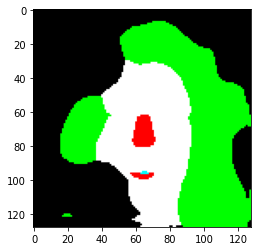

In [19]:
import numpy as np
images = images.to(device)
test_predict = face_parsing_model(images)
## get first predicted
pred_out = torch.argmax(test_predict[0], dim=0)
test_sam = pred_out.cpu().numpy()
parsed = decode_segmap(test_sam)
plt.imshow(parsed)

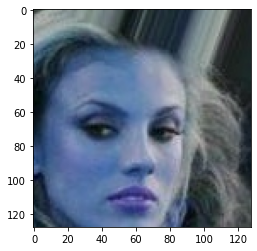

In [20]:
plt.imshow(return_image_numpy(images))